### **IMPORT LIBRARY**


In [5]:
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
import matplotlib.pyplot as plt
import pickle
import sys

### **FUNCTION DECLARATION**


In [2]:
def forwPass(X, w):
    '''
    Functionality module to do a forward propagation through given weights and input data.
    
    Parameters
    ----------
    X : numpy ndarray
       input data
    w : numpy ndarray
       weights to be used for forward propagation
    Returns
    -------
    numpy ndarray
       output of forward propagation

    '''
    return X@w.T

def lploss(processed_y, true_y, p = 2):
    '''
    Functionality module to calculate the loss of the model.
    
    Parameters
    ----------
    processed_y : numpy ndarray
        output of forward propagation on quantized weights
    true_y : numpy ndarray
        output of forward propagation on orginal weights
    p : int (default = 2)
        dimension space of lp norm

    '''
    return (np.sum(np.abs(true_y - processed_y)**p))**(1/p)

# Finding losses for different range threshold
def loss_ran_thres(X, w, true_y, callbacklossfn, step = 0.001, p = 2 ):
    '''
    Functionality module to calculate the loss of the weight for varying thresholds.

    Parameters
    ----------
    X : numpy ndarray
        input data for the forward popogation
    w : numpy ndarray
        copy of the weights analysis
    true_y : numpy ndarray
        output of forward propagation on orginal weights
    callbacklossfn : function
        loss function to calculate the loss of original output with output of pruned weights outcome
    step : float (default = 0.001)
        step size to create evenly spaced valued over min and max of the original weights
    p : int (default = 2)
        dimension space of lp norm

    Returns
    -------
    (list, list)
        holds the tuple of thresholds and respective loss values (magnitude, loss)
    '''
    local_min = np.min(w)
    local_max = np.max(w)
    points = int((local_max - local_min)/step)
    print("Local minimum: ", local_min, " Local max: ", local_max, "Points: ", points)

    mags = list(np.linspace(local_min, local_max, num= points, endpoint=False))

    losses = []
    
    for mag in mags:
        w[(w < mag)] = 0
        
        y = forwPass(X, w)
        loss = callbacklossfn(y, true_y, p)
        
        losses.append(loss)

    return mags, losses

def SmoothRollingAverage(samples, window_size=5, mode='same'):
    """
    Smoothing given data via rolling average.

    Parameters
    ----------
    samples : numpy ndarray (1D)
        data samples on which smoothing is applied
    window_size : int (default = 5)
        convolution of kernel size
    mode : str (default ='same')
        covolution mode type

    Returns
    -------
    numpy ndarray (1D)
        returns smooth data
    """

    kernel = np.ones(window_size)/window_size
    conv_output = np.convolve(samples, kernel, mode)
    return conv_output

def findRanges(True_Index, Slope, Threshold):
    """
    Functionality to extracted region based on binary indicator array

    Parameters
    ----------
    True_Index : numpy ndarray (1D)
        Array which holds the the importance of elements at corresponding indices, represented as 0 or 1
    Slope : numpy ndarray (1D)
        Array of slopes values 
    Threshold : numpy ndarray (1D)
        Array of thresholds values

    Returns
    -------
    list(tuple)
        returns the list of extracted region as tuple, containing the subarray of slope values and thresholds values
    """

    # Holdding all the region of interest
    ListOfRegions = []

    # Temporary variable to hold the region of iteration
    SlopeRegion = []
    ThresholdRegion = []

    # For each individual element in the Slope 
    for index, value in enumerate(True_Index):

        # Case when the element is saved as a region
        if value == 1:
            SlopeRegion.append(Slope[index])
            ThresholdRegion.append(Threshold[index])
        
        # When the region is interupted, saving the observed region
        elif value == 0 and SlopeRegion and ThresholdRegion:
            ListOfRegions.append((np.array(SlopeRegion), np.array(ThresholdRegion)))
            SlopeRegion = []
            ThresholdRegion = []
    # Termination case if last region is not interrupted and iterated till end
    if SlopeRegion and ThresholdRegion:
        ListOfRegions.append((np.array(SlopeRegion), np.array(ThresholdRegion)))

    # Returning the list of regions
    return ListOfRegions

def findLargestRegion(ListOfRegions, Range):
    """
    Function helps is finding the first two largest ranges in given list of ranges.

    Parameters
    ----------
    ListOfRegions : list(tuple)
        Contains the list of ranges in tuple (slopes values array, thresholds values array)
    Range : float
        Magnitude of difference between min max thresholds values

    Returns
    -------
    list(tuple)
        returns only the first two largest regions.

    """
    # Temporary variable to have the index of the largest ranges
    FirstRegionIndex = (-1, -1)
    SecondRegionIndex = (-1,-1)

    # For each individual element in the ListOfRegions
    for index, (SlopeRegion, ThresholdRegion) in enumerate(ListOfRegions):
        subRange = np.max(ThresholdRegion) - np.min(ThresholdRegion)

        # Checking percentage of region it convers
        if subRange/Range > FirstRegionIndex[0]:
            SecondRegionIndex = FirstRegionIndex
            FirstRegionIndex = (subRange/Range, index)
        elif subRange/Range > SecondRegionIndex[0]:
            SecondRegionIndex = (subRange/Range, index)

    print(FirstRegionIndex, SecondRegionIndex)
    
    # returns the region
    return [ListOfRegions[FirstRegionIndex[1]], ListOfRegions[SecondRegionIndex[1]]]

def quantizeConfig(Ranges):
    """
    Functions helps in finding the levels and returns the level mapping and and region ranges

    Parameters
    ----------
    Ranges : list(tuple)
        Selected region of to quantize for.

    Returns
    -------
    (dict, [tuples])
        Returns the level mapping and region ranges
    """

    [FirstRange, SecondRange] = Ranges

    # First Range
    FirstSlope, FirstThreshold = FirstRange
    FirstStartThreshold, FirstEndThreshold = FirstThreshold[0], FirstThreshold[-1]

    possible_levels = np.linspace(FirstStartThreshold, FirstEndThreshold, num=4)
    FirstLevelMapping = dict(zip(range(2), possible_levels[1:3]))

    # Second Range
    SecondSlope, SecondThreshold = SecondRange    
    SecondStartThreshold, SecondEndThreshold = SecondThreshold[0], SecondThreshold[-1]

    possible_levels = np.linspace(SecondStartThreshold, SecondEndThreshold, num=4)
    SecondLevelMapping = dict(zip(range(2, 4), possible_levels[1:3]))

    # Merging levels maps
    LevelMapping = FirstLevelMapping | SecondLevelMapping
    
    return (LevelMapping, [(FirstThreshold[0], FirstThreshold[-1]), (FirstThreshold[0], FirstThreshold[-1])])

def quantize(Weight, Mapping):
   '''
    Functionality module for quantizing the weights
    
    Parameters
    ----------
    Weight : numpy ndarray
        weight matrix which needs to be quantized
    Mapping : dict
        quantization points
        
    Returns
    -------
    numpy ndarray
       Quantized weights

    '''
   M1 = Weight - Mapping[0]
   M2 = Weight - Mapping[1]
   M3 = Weight - Mapping[2]
   M4 = Weight - Mapping[3]

   Subs = np.dstack((np.abs(M1),np.abs(M2),np.abs(M3),np.abs(M4)))
   Quant = np.argmin(Subs,axis=2)

   return Quant

def dequantize(Quant_weight, Mapping):

    """
    Functionality module for dequantizing the weights
    
    Parameters
    ----------
    Quant_weight : numpy ndarray
       quantized weight matrix
    Mapping : dict
        quantization points
        
    Returns
    -------
    numpy ndarray
       Dequantized weights

    """

    # 
    level0 = (Quant_weight == 0)*Mapping[0]
    level1 = (Quant_weight == 1)*Mapping[1]
    level2 = (Quant_weight == 2)*Mapping[2]
    level3 = (Quant_weight == 3)*Mapping[3]

    dequantize_weight = level0 + level1 + level2 + level3

    return dequantize_weight

def pruneIndex(Weight, Limits):
    """
    For given weight range, finds the index of pruning weights and returns the corresponding index as sparse
    
    Parameters
    ----------
    Weight : numpy ndarray
        original layer weight matrix
    range : tuple
        holds the limits of the pruning weights range

    Returns
    -------
    numpy sparse ndarray
       Pruning weights indexes

    """
    # Pruning conditions 
    LeftCase = Weight > Limits[0]
    RightCase = Weight < Limits[1]
    Index = LeftCase & RightCase

    # Conversion to sparse matrix
    SparseIndex = sparse.coo_matrix(Index)
    
    # returns
    return SparseIndex

### **LOADING LAYER WEIGHT AND LAYER SELECTION**


In [6]:
# Weights file names
bert_weight_name = 'bert-base-uncased'

# Loading bert model
with open(f'../saved/weights_only/{bert_weight_name}_weights.pkl','rb') as file:
    bert_weights_dict = pickle.load(file)

weight = bert_weights_dict['encoder.layer.9.attention.self.value.weight']

### **LOSS - RANGE GRAPH**


Local minimum:  -0.19814117  Local max:  0.20933148 Points:  407


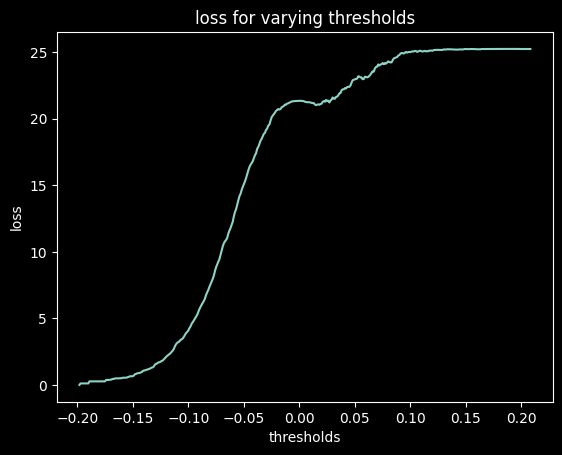

In [4]:
X_sample = np.random.randn(1, weight.shape[0])
Y_original = forwPass(X_sample, weight) 
Thresholds, Loss = loss_ran_thres(X_sample, weight.copy(), Y_original, lploss)

# Smoothing loss function
# Loss = SmoothRollingAverage(Loss, window_size=5, mode='same')

plt.plot(Thresholds, Loss)
plt.ylabel('loss')
plt.xlabel('thresholds')
plt.title('loss for varying thresholds')
plt.show()

### **SLOPE PLOT**


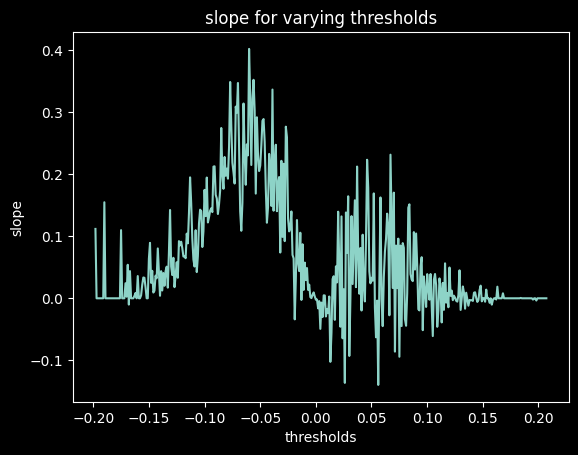

In [5]:
Thresholds = np.array(Thresholds)
Loss = np.array(Loss)

Slope = Loss[1:] - Loss[:-1]
plt.plot(Thresholds[:-1], Slope)
plt.xlabel('thresholds')
plt.ylabel('slope')
plt.title('slope for varying thresholds')
plt.show()

### **SMOOTHENED SLOPE PLOT**


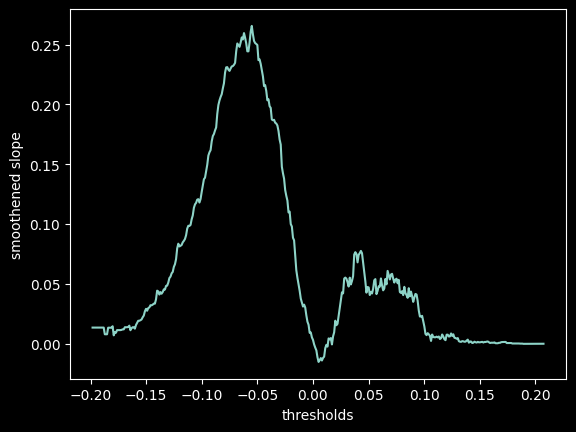

In [6]:
Smooth_samples = SmoothRollingAverage(Slope, window_size=20)
# Smooth_samples = savgol_filter(Slope, window_length=50, polyorder=6)

plt.plot(Thresholds[:-1], Smooth_samples)
plt.xlabel('thresholds')
plt.ylabel('smoothened slope')
plt.show()


### **SMOOTH SLOPE GRAPHA WITH CUT THRESHOLD**


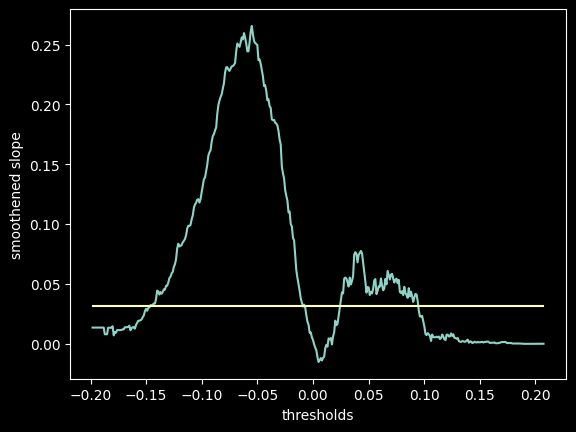

In [7]:
Slope_threshold = np.mean(Smooth_samples)

Sensitivity = 0.50
Cut_line = Sensitivity*Slope_threshold*np.ones(Smooth_samples.shape)


plt.plot(Thresholds[:-1], Smooth_samples, Thresholds[:-1], Cut_line)
plt.xlabel('thresholds')
plt.ylabel('smoothened slope')
plt.show()

### **POSSIBLE REGION OF SELECTION PLOT**


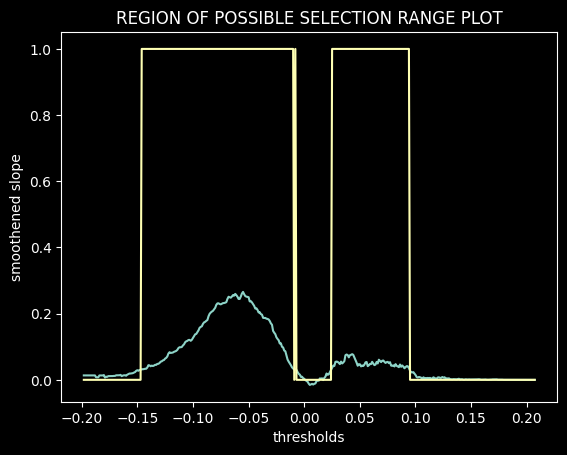

In [8]:
True_Index = Smooth_samples > Sensitivity*Slope_threshold

plt.plot(Thresholds[:-1], Smooth_samples, Thresholds[:-1], True_Index)
plt.title('REGION OF POSSIBLE SELECTION RANGE PLOT')
plt.xlabel('thresholds')
plt.ylabel('smoothened slope')
plt.show()

### **REGION OF SELECTION PLOT**


(0.3349753694581281, 0) (0.16995073891625617, 2)


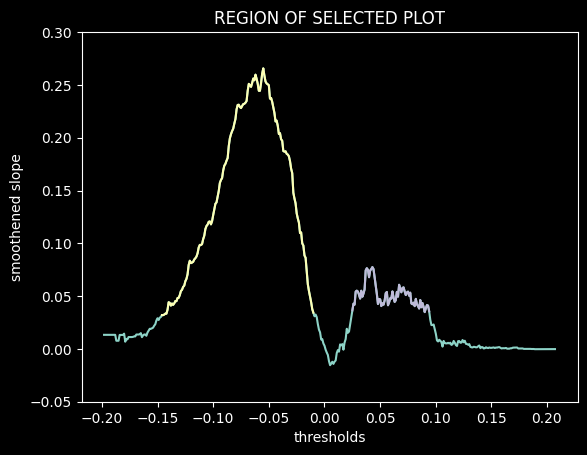

In [9]:
Regions = findRanges(True_Index, Smooth_samples, Thresholds)
R = np.max(Thresholds) - np.min(Thresholds)

[FirstRange, SecondRange] = findLargestRegion(Regions, R)
plt.plot(Thresholds[:-1], Smooth_samples, FirstRange[1], FirstRange[0], SecondRange[1], SecondRange[0])
plt.ylim([-0.05, 0.3])
plt.title('REGION OF SELECTED PLOT')
plt.xlabel('thresholds')
plt.ylabel('smoothened slope')
plt.show()


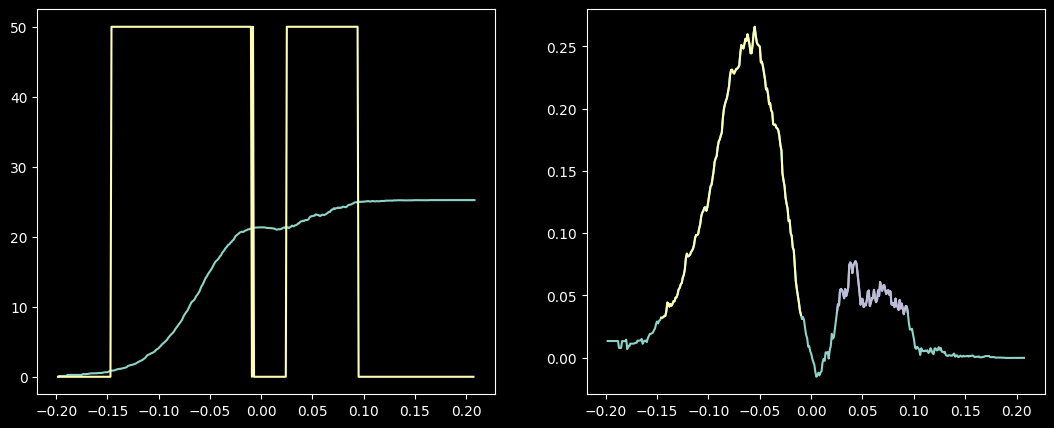

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(13, 5)

ax[0].plot(Thresholds, Loss, Thresholds[:-1],50*True_Index)
ax[1].plot(Thresholds[:-1], Smooth_samples, FirstRange[1], FirstRange[0], SecondRange[1], SecondRange[0])

### **FINDING QUANTIZATION LEVELS**


<StemContainer object of 3 artists>

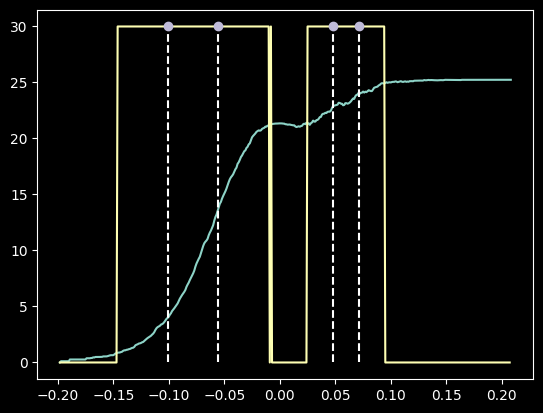

In [11]:
Mapping, RangeLimits = quantizeConfig([FirstRange, SecondRange])

plt.plot(Thresholds, Loss,  Thresholds[:-1],30*True_Index)
plt.stem([Mapping[0], Mapping[1], Mapping[2], Mapping[3]], 4*[30],  basefmt=" ", linefmt='--')

In [12]:
Quant = [Mapping[0],Mapping[1],Mapping[2],Mapping[3]]

# finding the closest number index from the quantized weights
def closest_number(given_number):
    '''
    input : weight to be quantized
    output : quantized weights
    '''
    closest = None
    min_difference = float('inf')
    
    for i,num in enumerate(Quant):
        difference = abs(given_number - num)
        if difference < min_difference:
            min_difference = difference
            closest = i
    
    return closest


quant_weight = np.zeros(weight.shape)

# iterate through the weights and set the quantization levels
for rindex,i in enumerate(weight):
    for colindex,j in enumerate(i):

        # quant_weight - quantized weight matrix
        quant_weight[rindex][colindex] = closest_number(weight[rindex][colindex])

### **QUANTIZATION AND DEQUANTIZATION**


In [13]:
quant_weight = quantize(weight, Mapping)
dequant_weight = dequantize(quant_weight, Mapping)

dequant_weight

array([[-0.05530882,  0.04814451,  0.04814451, ...,  0.04814451,
         0.04814451,  0.07117122],
       [-0.05530882,  0.04814451, -0.05530882, ...,  0.04814451,
         0.04814451,  0.04814451],
       [ 0.04814451, -0.05530882,  0.04814451, ...,  0.04814451,
        -0.05530882, -0.05530882],
       ...,
       [ 0.04814451,  0.04814451, -0.05530882, ...,  0.04814451,
        -0.05530882,  0.04814451],
       [ 0.04814451,  0.04814451, -0.05530882, ..., -0.05530882,
        -0.05530882, -0.05530882],
       [-0.05530882,  0.04814451, -0.05530882, ...,  0.04814451,
        -0.05530882,  0.04814451]])

### **PRUNING INDEX EXTRACTION**


In [21]:
Index = pruneIndex(weight, (-0.01, 0.01))

Data = Index.toarray()

sys.getsizeof(Index)

48

### **ERROR WEIGHT ANALYSIS**


In [4]:
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
import matplotlib.pyplot as plt
import pickle
import sys

# Adding path to py files
sys.path.append('../')

# Importing the custom quantization module
from CustomQuantization import CustomQuantization as quant
from utils import *

In [13]:
# Weights file names
bert_weight_name = 'bert-base-uncased'

# Loading bert model
with open(f'../saved/weights_only/{bert_weight_name}_weights.pkl','rb') as file:
    bert_weights_dict = pickle.load(file)

weight = bert_weights_dict['encoder.layer.4.attention.self.value.weight']

In [94]:
QuantizationObject = quant()

# Finding suitable weight range 
QuantizationObject.extractRange(weight.copy())

# Applying quantization
QuantizationObject.proceedQuantization(weight.copy())

quant_weight = QuantizationObject.dequantize()

Local minimum:  -0.20894077  Local max:  0.20931585 Points:  418
Ratio of first region range coverage: 0.3653846153846154 Region of selection index:  1
Ratio of second region range coverage: 0.040865384615384547 Region of selection index:  2
(-0.002814303245841032, 0.058223146891765054)


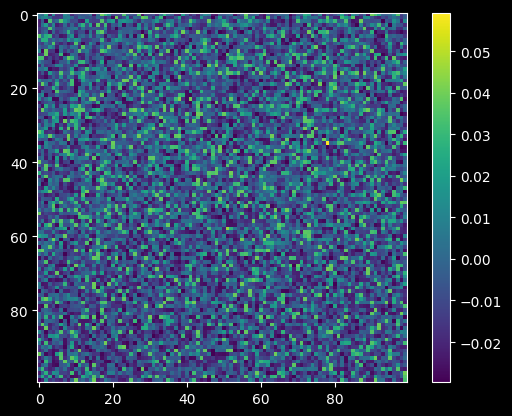

In [22]:
error_weight  = weight - QuantizationObject.dequantize()
plt.imshow(error_weight[:100, :100])
plt.colorbar()

Mean: 5.983287701383233e-05
Standard deviation: 0.034907128661870956


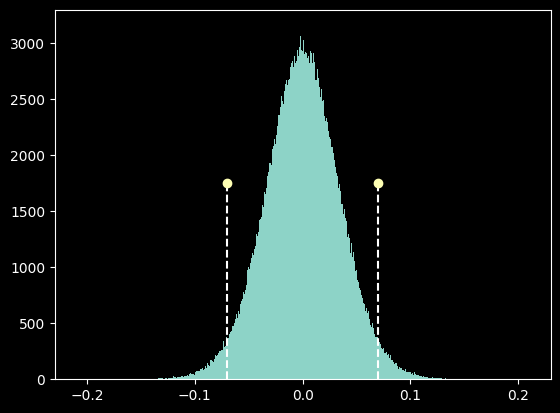

In [88]:
mean = np.mean(weight)
std = np.std(weight)

print(f'Mean: {mean}')
print(f'Standard deviation: {std}')
E = error_weight.flatten()

plt.hist(weight.flatten(),bins=1000)
plt.stem([-2*std, 2*std], [1750, 1750], basefmt=' ', linefmt='--')
plt.show()

In [89]:
OutlinerIndex_r = weight > 2*std
OutlinerIndex_l = weight < -2*std

OutlinerIndex = OutlinerIndex_l + OutlinerIndex_r

OutlinerPercentage = np.sum(OutlinerIndex)/(weight.shape[0]*weight.shape[1])
print("Number of outliers: ",np.sum(OutlinerIndex))
print('Ratio of Outlier and total number of parameters: ', OutlinerPercentage)

Number of outliers:  28282
Ratio of Outlier and total number of parameters:  0.047949896918402776


### **IMPACT OF THESE OUTLINERS**


In [92]:
X_sample = np.random.randn(1, weight.shape[1])

Y_output = forwPass(X_sample, weight)
Y_quant_output = forwPass(X_sample, QuantizationObject.dequantize())

Y_withOutliner_output = forwPass(X_sample, QuantizationObject.dequantize() + np.multiply(error_weight, OutlinerIndex))

Loss_with_Outlinercorrection = lploss(Y_withOutliner_output, Y_output)
Loss_without_Outlinercorrection = lploss(Y_quant_output, Y_output)

print("Loss with inclusive of outliers: ", Loss_with_Outlinercorrection)
print("Loss without inclusive of outliers: ", Loss_without_Outlinercorrection)

print("Percentage of decrease in the loss by outliers: ", (1 - Loss_with_Outlinercorrection/Loss_without_Outlinercorrection) *100)

Loss with inclusive of outliers:  14.64775683097097
Loss without inclusive of outliers:  15.142436746259813
Percentage of decrease in the loss by outliers:  3.2668448518434756


### **LOCAL CHANNEL TRAINING OUTLINERS**


In [133]:
import torch, torch.optim as optim

def lpSpace(Input, p = 2):
    '''
    input : input tensor
    p : power of the norm
    '''
    return torch.norm(Input, p)

**ONLY WITH OUTPUT LOSS**


In [162]:
# INITIALIZATION
QuantWeight_tensor = torch.tensor(quant_weight, requires_grad=False)

GradientUpdates = torch.tensor(np.multiply(error_weight, OutlinerIndex), requires_grad=True)

N =100
learning_rate = 0.001
optimiser = optim.SGD([GradientUpdates], learning_rate)

# TRAINING
X_sample = torch.randn(10, weight.shape[1], dtype=torch.double)
Y_output = forwPass(X_sample, QuantWeight_tensor)

for epoch in range(N):

    for i, each in enumerate(X_sample):
        optimiser.zero_grad()
        output = forwPass(each, QuantWeight_tensor + GradientUpdates)
        diff = Y_output[i,:] - output
        loss = lpSpace(diff)
        loss.backward()
        optimiser.step()


# ANALYSIS
X_sample = np.random.randn(1, weight.shape[1])
GradientUpdates_numpy = GradientUpdates.detach().numpy()

Y_output = forwPass(X_sample, weight)
Y_quant_output = forwPass(X_sample, QuantizationObject.dequantize())

Y_withOutliner_output = forwPass(X_sample, QuantizationObject.dequantize() + np.multiply(GradientUpdates_numpy, OutlinerIndex))

Loss_with_Outlinercorrection = lploss(Y_withOutliner_output, Y_output)
Loss_without_Outlinercorrection = lploss(Y_quant_output, Y_output)

print("Loss with inclusive of outliers: ", Loss_with_Outlinercorrection)
print("Loss without inclusive of outliers: ", Loss_without_Outlinercorrection)

print("Percentage of decrease in the loss by outliers: ", (1 - Loss_with_Outlinercorrection/Loss_without_Outlinercorrection) *100)

Loss with inclusive of outliers:  14.046854137584573
Loss without inclusive of outliers:  13.691449085095009
Percentage of decrease in the loss by outliers:  -2.595817654366983


**WITH OUTPUT LOSS AND L1 NORM OF ERROR WEIGHT**


In [164]:
# INITIALIZATION
QuantWeight_tensor = torch.tensor(quant_weight, requires_grad=False)
OutlinerIndex_tensor = torch.tensor(OutlinerIndex, requires_grad=False)

GradientUpdates = torch.tensor(np.multiply(error_weight, OutlinerIndex), requires_grad=True)

N =100
learning_rate = 0.001
optimiser = optim.SGD([GradientUpdates], learning_rate)

# TRAINING
X_sample = torch.randn(10, weight.shape[1], dtype=torch.double)
Y_output = forwPass(X_sample, QuantWeight_tensor)

for epoch in range(N):

    for i, each in enumerate(X_sample):
        optimiser.zero_grad()

        output = forwPass(each, QuantWeight_tensor + GradientUpdates)
        diff = Y_output[i,:] - output
        loss = lpSpace(diff) + torch.norm(GradientUpdates, p = 1)

        loss.backward()
        optimiser.step()


# ANALYSIS
X_sample = np.random.randn(1, weight.shape[1])
GradientUpdates_numpy = GradientUpdates.detach().numpy()

Y_output = forwPass(X_sample, weight)
Y_quant_output = forwPass(X_sample, QuantizationObject.dequantize())

Y_withOutliner_output = forwPass(X_sample, QuantizationObject.dequantize() + np.multiply(GradientUpdates_numpy, OutlinerIndex))

Loss_with_Outlinercorrection = lploss(Y_withOutliner_output, Y_output)
Loss_without_Outlinercorrection = lploss(Y_quant_output, Y_output)

print("Loss with inclusive of outliers: ", Loss_with_Outlinercorrection)
print("Loss without inclusive of outliers: ", Loss_without_Outlinercorrection)

print("Percentage of decrease in the loss by outliers: ", (1 - Loss_with_Outlinercorrection/Loss_without_Outlinercorrection) *100)

Loss with inclusive of outliers:  14.248921965130318
Loss without inclusive of outliers:  14.25140776683342
Percentage of decrease in the loss by outliers:  0.017442499321973504


**WITH OUTPUT LOSS AND L2 NORM OF ERROR WEIGHT**


In [165]:
# INITIALIZATION
QuantWeight_tensor = torch.tensor(quant_weight, requires_grad=False)
OutlinerIndex_tensor = torch.tensor(OutlinerIndex, requires_grad=False)

GradientUpdates = torch.tensor(np.multiply(error_weight, OutlinerIndex), requires_grad=True)

N =100
learning_rate = 0.001
optimiser = optim.SGD([GradientUpdates], learning_rate)

# TRAINING
X_sample = torch.randn(10, weight.shape[1], dtype=torch.double)
Y_output = forwPass(X_sample, QuantWeight_tensor)

for epoch in range(N):

    for i, each in enumerate(X_sample):
        optimiser.zero_grad()

        output = forwPass(each, QuantWeight_tensor + GradientUpdates)
        diff = Y_output[i,:] - output
        loss = lpSpace(diff) + torch.norm(GradientUpdates, p = 2)

        loss.backward()
        optimiser.step()


# ANALYSIS
X_sample = np.random.randn(1, weight.shape[1])
GradientUpdates_numpy = GradientUpdates.detach().numpy()

Y_output = forwPass(X_sample, weight)
Y_quant_output = forwPass(X_sample, QuantizationObject.dequantize())

Y_withOutliner_output = forwPass(X_sample, QuantizationObject.dequantize() + np.multiply(GradientUpdates_numpy, OutlinerIndex))

Loss_with_Outlinercorrection = lploss(Y_withOutliner_output, Y_output)
Loss_without_Outlinercorrection = lploss(Y_quant_output, Y_output)

print("Loss with inclusive of outliers: ", Loss_with_Outlinercorrection)
print("Loss without inclusive of outliers: ", Loss_without_Outlinercorrection)

print("Percentage of decrease in the loss by outliers: ", (1 - Loss_with_Outlinercorrection/Loss_without_Outlinercorrection) *100)

Loss with inclusive of outliers:  13.124112244124083
Loss without inclusive of outliers:  13.012771894281277
Percentage of decrease in the loss by outliers:  -0.8556236192208688


**WITH OUTPUT LOSS AND L1 NORM AND L2 NORM OF ERROR WEIGHT**


In [166]:
# INITIALIZATION
QuantWeight_tensor = torch.tensor(quant_weight, requires_grad=False)
OutlinerIndex_tensor = torch.tensor(OutlinerIndex, requires_grad=False)

GradientUpdates = torch.tensor(np.multiply(error_weight, OutlinerIndex), requires_grad=True)

N =100
learning_rate = 0.001
optimiser = optim.SGD([GradientUpdates], learning_rate)

# TRAINING
X_sample = torch.randn(10, weight.shape[1], dtype=torch.double)
Y_output = forwPass(X_sample, QuantWeight_tensor)

for epoch in range(N):

    for i, each in enumerate(X_sample):
        optimiser.zero_grad()

        output = forwPass(each, QuantWeight_tensor + GradientUpdates)
        diff = Y_output[i,:] - output
        loss = lpSpace(diff) + torch.norm(GradientUpdates, p = 1) + torch.norm(GradientUpdates, p = 2)

        loss.backward()
        optimiser.step()


# ANALYSIS
X_sample = np.random.randn(1, weight.shape[1])
GradientUpdates_numpy = GradientUpdates.detach().numpy()

Y_output = forwPass(X_sample, weight)
Y_quant_output = forwPass(X_sample, QuantizationObject.dequantize())

Y_withOutliner_output = forwPass(X_sample, QuantizationObject.dequantize() + np.multiply(GradientUpdates_numpy, OutlinerIndex))

Loss_with_Outlinercorrection = lploss(Y_withOutliner_output, Y_output)
Loss_without_Outlinercorrection = lploss(Y_quant_output, Y_output)

print("Loss with inclusive of outliers: ", Loss_with_Outlinercorrection)
print("Loss without inclusive of outliers: ", Loss_without_Outlinercorrection)

print("Percentage of decrease in the loss by outliers: ", (1 - Loss_with_Outlinercorrection/Loss_without_Outlinercorrection) *100)

Loss with inclusive of outliers:  13.661077951358697
Loss without inclusive of outliers:  13.661406259861137
Percentage of decrease in the loss by outliers:  0.0024031823385839424
